In [1]:
!pip install cirq

     |████████████████████████████████| 1.6 MB 9.5 MB/s 
     |████████████████████████████████| 437 kB 35.1 MB/s 
     |████████████████████████████████| 47 kB 3.7 MB/s 
     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 328 kB 41.1 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 65 kB 2.2 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 145 kB 43.0 MB/s 
     |████████████████████████████████| 220 kB 38.4 MB/s 
     |████████████████████████████████| 10.1 MB 9.8 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 229 kB 54.0 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 243 kB 61.9 MB/s 
     |█████████████████████████

In [2]:
import numpy as np
import random
import time
import itertools as itert
import cirq
import matplotlib.pyplot as plt
import math


Deutsche Jozsa

In [3]:
def createUfDJ(n, fntype, verbose = True):
    ufMatrix = np.zeros((2**n,2**n))

    # Constant Function
    if fntype == 0:
        typeOfFn = np.random.randint(low = 0, high = 2)
        if verbose:
            print('Function is constant ', typeOfFn)

        # Constant 0 means f(x) = 0 always and hence the qubits remain as such. Identity Matrix
        if typeOfFn == 0:
            return np.eye(2**n)

        # Constant 1. Here we change the last qubit alone as (b xor 1). Which means we change the last bit alone.
        for i in range(2**n):
            if i % 2 == 0:
                ufMatrix[i+1][i] = 1
            else:
                ufMatrix[i-1][i] = 1
    else:
        ufMatrix = np.eye(2**n)

        # For half the inputs f(x) = 0, so they have x,x value of matrix as 1. For the rest, we need to swap the last bit. We need to take half of possible x values, without helper qubit.
        randList = random.sample(range(0, 2**(n-1)), 2**(n-2))
        for val in randList:
            # For each of the x, helper qubit can be 0 or 1. Handle both cases. Added last bit 0, is same as (*2) and last 1 is (*2 + 1)

            ufMatrix[val*2][val*2] = 0
            ufMatrix[val*2 + 1][val*2 + 1] = 0
            ufMatrix[val*2 + 1][val*2] = 1
            ufMatrix[val*2][val*2 + 1] = 1

    if verbose:
        print("Matrix Uf:")
        print(ufMatrix)

    return ufMatrix
        
class Oracle(cirq.Gate):
    def __init__(self, n, ufMatrix, name):
        self.__n = n
        self.__ufMatrix = ufMatrix
        self.__name = name

    def num_qubits(self):
        return self.__n 

    def _unitary_(self):
        return np.squeeze(np.asarray(self.__ufMatrix))
        
    def __str__(self):
        return self.__name

def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

def runAndPrint(n, qubits, ufMatrix, verbose):
    # Time taken by program needs to be checked.
    start = time.time()
    # Defining start of Cirq program
    c = cirq.Circuit()

    # setting last qubit to 1
    c.append(cirq.X(qubits[n-1]))
    
    # adding Hadamard gates to all qubits
    for i in range(0,n):
        c.append([cirq.H(qubits[i])])
    
    # creating Uf gate
    uf_bv = Oracle(n, ufMatrix, "UF")
    
    # adding Uf gate
    c.append(uf_bv(*qubits))
    
    # helper bit does not require H gate. Result is treated as trash/ garbage    
    for i in range(0,n):
        c.append([cirq.H(qubits[i])])        
    
    # measurements
    c.append(cirq.measure(*qubits[:-1], key='result'))
       
    mid = time.time()

    simulator = cirq.Simulator()
    
    result = simulator.run(c, repetitions = 30)
    end = time.time()

    if verbose:
        print("Circuit used to solve problem: ")
        print(c)
    
        print("Results: ")
        print(result)

        frequencies = result.histogram(key="result", fold_func = bitstring)
        print('Sampled results:\n{}'.format(frequencies))
        _ = cirq.vis.plot_state_histogram(frequencies, plt.subplot())

        print("Time taken to create circuit: ", mid - start)
        print("Time taken for execution: ", end - mid)
        print("Time taken by program: ", end - start)

    return (mid - start, end - mid)

# typeOfFn of 0 implies constant functions. 1 implies uniform.
def runMainCircuitDJ(n = 0, typeOfFn = -1, verbose = True):
    # Taking the input n from the user
    if(n == 0):
        n = int(input("Enter length of function input: "))
    elif verbose:
        print('Input Length: ', n)

    n = n + 1
    # Defining n + 1 qubits 
    qubits = cirq.LineQubit.range(n)

    if typeOfFn == -1:
        typeOfFn = np.random.randint(low = 0, high = 2)
    if verbose:
        print('Type: ', typeOfFn)

    ufMatrix = createUfDJ(n, typeOfFn, verbose)

    return runAndPrint(n, qubits, ufMatrix, verbose)

Input Length:  1
Type:  1
Matrix Uf:
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │
1: ───X───H───#2───H─────────────────
Results: 
result=111111111111111111111111111111
Sampled results:
Counter({'1': 30})
Time taken to create circuit:  0.001163482666015625
Time taken for execution:  0.026203155517578125
Time taken by program:  0.02736663818359375
0.001163482666015625 0.026203155517578125


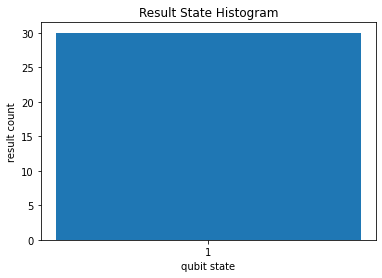

In [4]:
(circuitTime, runTime) = runMainCircuitDJ(1)
print (circuitTime, runTime)

Correctness Tests

Input Length:  1
Type:  0
Function is constant  1
Matrix Uf:
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │
1: ───X───H───#2───H─────────────────
Results: 
result=000000000000000000000000000000
Sampled results:
Counter({'0': 30})
Time taken to create circuit:  0.0010895729064941406
Time taken for execution:  0.005316972732543945
Time taken by program:  0.006406545639038086


(0.0010895729064941406, 0.005316972732543945)

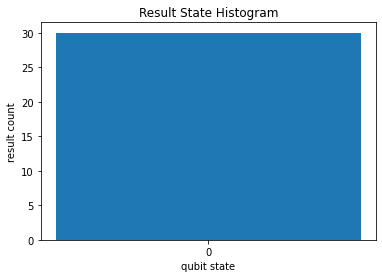

In [5]:
# Constant n = 1
runMainCircuitDJ(1, 0)

Input Length:  1
Type:  1
Matrix Uf:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │
1: ───X───H───#2───H─────────────────
Results: 
result=111111111111111111111111111111
Sampled results:
Counter({'1': 30})
Time taken to create circuit:  0.001066446304321289
Time taken for execution:  0.004929542541503906
Time taken by program:  0.005995988845825195


(0.001066446304321289, 0.004929542541503906)

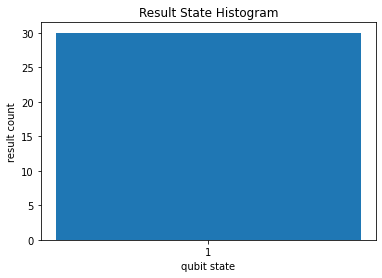

In [6]:
# Uniform n = 1
runMainCircuitDJ(1, 1)

Input Length:  2
Type:  0
Function is constant  0
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M─────────────
              │
2: ───X───H───#3───H─────────────────
Results: 
result=000000000000000000000000000000, 000000000000000000000000000000
Sampled results:
Counter({'00': 30})
Time taken to create circuit:  0.0011379718780517578
Time taken for execution:  0.006023406982421875
Time taken by program:  0.007161378860473633


(0.0011379718780517578, 0.006023406982421875)

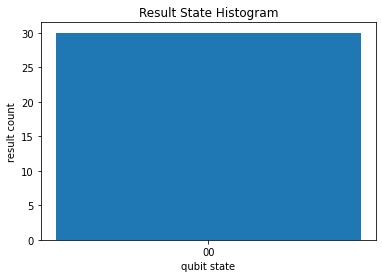

In [7]:
# Constant n = 2
runMainCircuitDJ(2, 0)

Input Length:  2
Type:  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M─────────────
              │
2: ───X───H───#3───H─────────────────
Results: 
result=000000000000000000000000000000, 111111111111111111111111111111
Sampled results:
Counter({'01': 30})
Time taken to create circuit:  0.0012204647064208984
Time taken for execution:  0.004635810852050781
Time taken by program:  0.00585627555847168


(0.0012204647064208984, 0.004635810852050781)

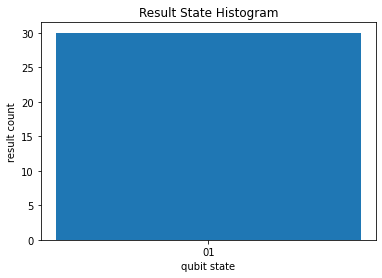

In [8]:
# Uniform n = 2
runMainCircuitDJ(2, 1)

Input Length:  3
Type:  0
Function is constant  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M───

(0.001603841781616211, 0.008084774017333984)

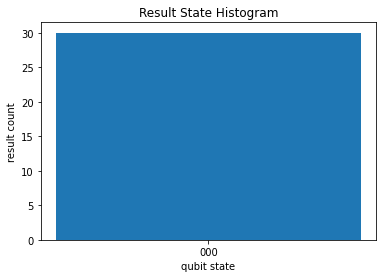

In [9]:
# Constant n = 3
runMainCircuitDJ(3, 0)

Input Length:  3
Type:  1
Matrix Uf:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M─────────────
             

(0.0008857250213623047, 0.00403904914855957)

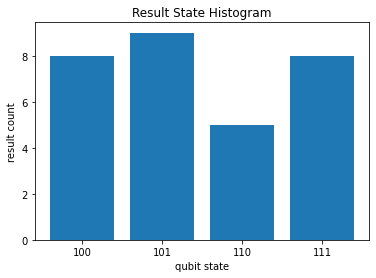

In [10]:
# Uniform n = 3
runMainCircuitDJ(3, 1)

Time for various Uf for n = 5 and Uniform

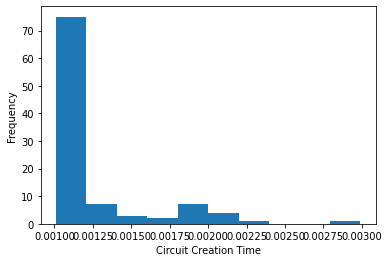

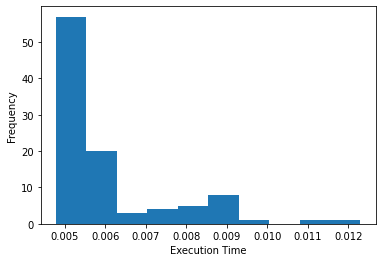

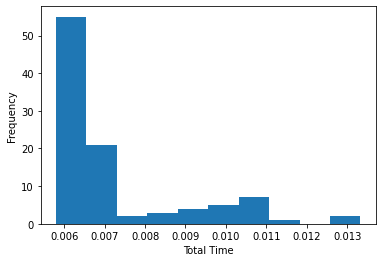

In [11]:
circuitTimes = []
executionTimes = []
totalTimes = []
for i in range(100):
    (circuit, execution) = runMainCircuitDJ(5, 1, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(circuit + execution)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(executionTimes)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(totalTimes)
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.show() 

Time difference for Constant functions (Only 2 possible) for n = 5

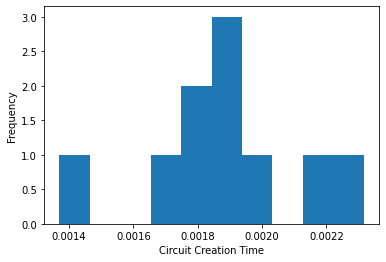

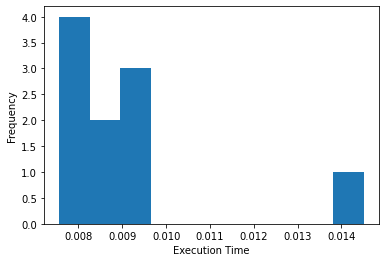

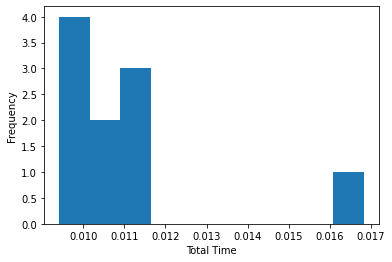

In [12]:
circuitTimes = []
executionTimes = []
totalTimes = []
for i in range(10):
    (circuit, execution) = runMainCircuitDJ(5, 0, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(circuit + execution)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(executionTimes)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(totalTimes)
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.show() 

Effect of n on execution time

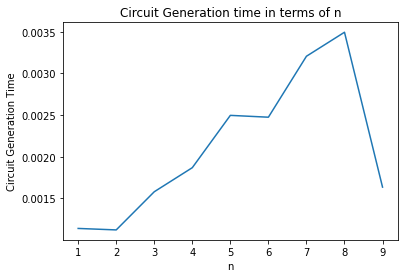

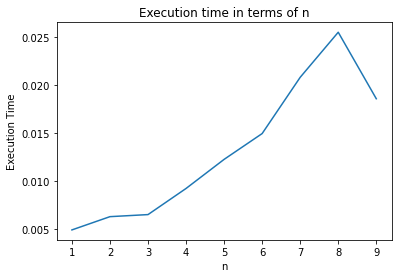

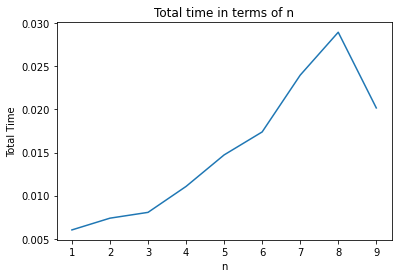

In [13]:
circuitTimes = []
executionTimes = []
totalTimes = []
for n in range(1, 10):
    ct = 0
    et = 0
    tt = 0
    for i in range(100):
        (circuit, execution) = runMainCircuitDJ(n, 1, False)
        ct += circuit
        et += execution
        tt += circuit + execution
    circuitTimes.append(ct / 100)
    executionTimes.append(et / 100)
    totalTimes.append(tt / 100)

x_axis = [1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time in terms of n')
plt.ylabel('Circuit Generation Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, executionTimes)
plt.title('Execution time in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, totalTimes)
plt.title('Total time in terms of n')
plt.ylabel('Total Time')
plt.xlabel('n')
plt.show() 

Berstein Vazirani

In [14]:
class Oracle(cirq.Gate):
    def __init__(self, n, ufMatrix, name):
        self.__n = n
        self.__ufMatrix = ufMatrix
        self.__name = name

    def num_qubits(self):
        return self.__n 

    def _unitary_(self):
        return np.squeeze(np.asarray(self.__ufMatrix))
        
    def __str__(self):
        return self.__name

def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

def runAndPrint(n, qubits, ufMatrix, verbose):
    # Time taken by program needs to be checked.
    start = time.time()
    # Defining start of Cirq program
    c = cirq.Circuit()

    # setting last qubit to 1
    c.append(cirq.X(qubits[n-1]))
    
    # adding Hadamard gates to all qubits
    for i in range(0,n):
        c.append([cirq.H(qubits[i])])
    
    # creating Uf gate
    uf_bv = Oracle(n, ufMatrix, "UF")
    
    # adding Uf gate
    c.append(uf_bv(*qubits))
    
    # helper bit does not require H gate. Result is treated as trash/ garbage    
    for i in range(0,n):
        c.append([cirq.H(qubits[i])])        
    
    # measurements
    c.append(cirq.measure(*qubits[:-1], key='result'))
       
    mid = time.time()

    simulator = cirq.Simulator()
    
    result = simulator.run(c, repetitions = 30)
    end = time.time()

    if verbose:
        print("Circuit used to solve problem: ")
        print(c)
    
        print("Results: ")
        print(result)

        frequencies = result.histogram(key="result", fold_func = bitstring)
        print('Sampled results:\n{}'.format(frequencies))
        _ = cirq.vis.plot_state_histogram(frequencies, plt.subplot())

        print("Time taken to create circuit: ", mid - start)
        print("Time taken for execution: ", end - mid)
        print("Time taken by program: ", end - start)

    return (mid - start, end - mid)

def decimalToBinary(x, n):
    s = bin(x).replace("0b", "")
    currsize = len(s)
    ans = '0' * (n - currsize)
    ans += s
    return ans

def getFx(x, a, b, n):
    # Last bit is the helper qubit
    xb = decimalToBinary(x, n+1)
    ab = decimalToBinary(a, n)

    # Add b
    val = b

    # Perform a.x
    for i in range(n):
        val += int(xb[i]) * int(ab[i])
    
    return (val % 2)

def createUfBV(n, a, b, verbose = True):
    ufMatrix = np.zeros((2**n,2**n))

    for i in range(2 ** n):
        val = getFx(i, a, b, n - 1)
        if val == 1:
            if i % 2 == 0:
                ufMatrix[i+1][i] = 1
            else:
                ufMatrix[i-1][i] = 1
        else:
            ufMatrix[i][i] = 1

    if verbose:
        print("Matrix Uf:")
        print(ufMatrix)

    return ufMatrix

def runMainCircuitBV(n = 0, verbose = True):
    # Taking the input n from the user
    if(n == 0):
        n = int(input("Enter length of function input: "))
    elif verbose:
        print('Input Length: ', n)

    n = n + 1

    b = np.random.randint(low = 0, high = 2)
    a = np.random.randint(low = 0, high = 2**(n-1))

    if verbose:
        print('a: ', decimalToBinary(a, n - 1))
        print('b: ', b)

    # Defining n + 1 qubits 
    qubits = cirq.LineQubit.range(n)

    ufMatrix = createUfBV(n, a, b, verbose)

    bval = getFx(0, a, b, n)

    if verbose:
        print('Expected b: ', bval)

    return runAndPrint(n, qubits, ufMatrix, verbose)

Correctness Tests:

Input Length:  1
a:  1
b:  1
Matrix Uf:
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Expected b:  1
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │
1: ───X───H───#2───H─────────────────
Results: 
result=111111111111111111111111111111
Sampled results:
Counter({'1': 30})
Time taken to create circuit:  0.0010690689086914062
Time taken for execution:  0.005074024200439453
Time taken by program:  0.006143093109130859


(0.0010690689086914062, 0.005074024200439453)

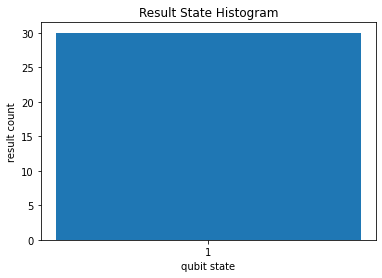

In [15]:
runMainCircuitBV(1)

Input Length:  2
a:  00
b:  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]
Expected b:  1
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M─────────────
              │
2: ───X───H───#3───H─────────────────
Results: 
result=000000000000000000000000000000, 000000000000000000000000000000
Sampled results:
Counter({'00': 30})
Time taken to create circuit:  0.002600431442260742
Time taken for execution:  0.009421586990356445
Time taken by program:  0.012022018432617188


(0.002600431442260742, 0.009421586990356445)

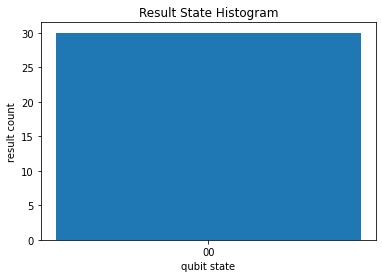

In [16]:
runMainCircuitBV(2)

Input Length:  3
a:  101
b:  1
Matrix Uf:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Expected b:  1
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M───────

(0.0009224414825439453, 0.004941701889038086)

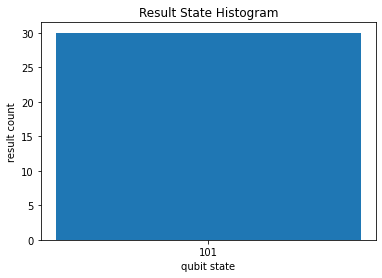

In [17]:
runMainCircuitBV(3)

Input Length:  4
a:  1001
b:  1
Matrix Uf:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
Expected b:  1
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M─────────────
              │        │
2: ───H───────#3───H───M─────────────
              │        │
3: ───H───────#4───H───M─────────────
              │
4: ───X───H───#5───H─────────────────
Results: 
result=111111111111111111111111111111, 000000000000000000000000000000, 000000000000000000000000000000, 111111111111111111111111111111
Sampled results:
Counter({'1001': 30})
Time taken to create circuit:  0.002212047576904297
Time taken for execution:  0.005755186080932617
Time taken by program:  0.007967233657836914


(0.002212047576904297, 0.005755186080932617)

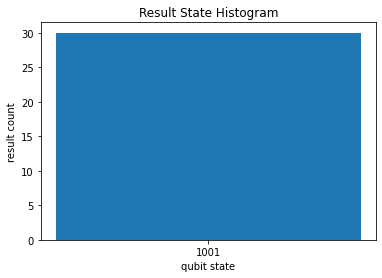

In [18]:
runMainCircuitBV(4)

Input Length:  5
a:  00010
b:  0
Matrix Uf:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
Expected b:  0
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M─────────────
              │        │
2: ───H───────#3───H───M─────────────
              │        │
3: ───H───────#4───H───M─────────────
              │        │
4: ───H───────#5───H───M─────────────
              │
5: ───X───H───#6───H─────────────────
Results: 
result=000000000000000000000000000000, 000000000000000000000000000000, 000000000000000000000000000000, 111111111111111111111111111111, 000000000000000000000000000000
Sampled results:
Counter({'00010': 30})
Time taken to create circuit:  0.002146005630493164
Time taken for execution:  0.006868600845336914
Time taken by program:  0.009014606475830078


(0.002146005630493164, 0.006868600845336914)

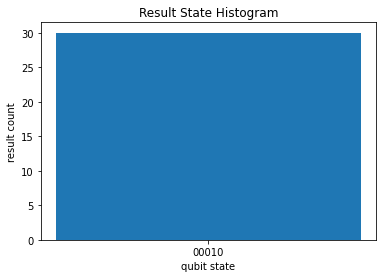

In [19]:
runMainCircuitBV(5)

Input Length:  6
a:  101010
b:  1
Matrix Uf:
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Expected b:  1
Circuit used to solve problem: 
0: ───H───────UF───H───M('result')───
              │        │
1: ───H───────#2───H───M─────────────
              │        │
2: ───H───────#3───H───M─────────────
              │        │
3: ───H───────#4───H───M─────────────
              │        │
4: ───H───────#5───H───M─────────────
              │        │
5: ───H───────#6───H───M─────────────
              │
6: ───X───H───#7───H─────────────────
Results: 
result=111111111111111111111111111111, 000000000000000000000000000000, 111111111111111111111111111111, 000000000000000000000000000000, 111111111111111111111111111111, 000000000000000000000000000000
Sampled results:
Counter({'101010': 30})
Time taken to create circuit:  0.003217935562133789
Time taken for execution:  0.009670257568359

(0.003217935562133789, 0.009670257568359375)

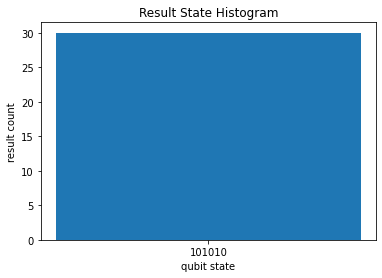

In [20]:
runMainCircuitBV(6)

Time for various Uf for n = 5

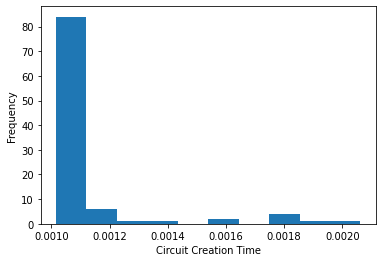

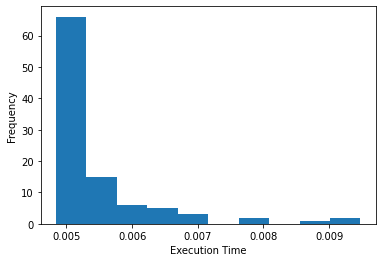

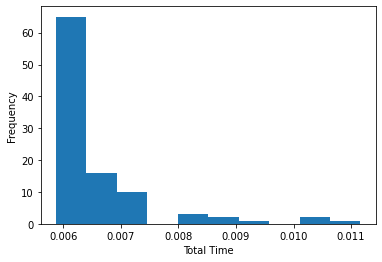

In [21]:
circuitTimes = []
executionTimes = []
totalTimes = []
for i in range(100):
    (circuit, execution) = runMainCircuitBV(5, False)
    circuitTimes.append(circuit)
    executionTimes.append(execution)
    totalTimes.append(circuit + execution)
plt.hist(circuitTimes)
plt.xlabel('Circuit Creation Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(executionTimes)
plt.xlabel('Execution Time')
plt.ylabel('Frequency')
plt.show() 

plt.hist(totalTimes)
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.show() 

Effect of n on execution time

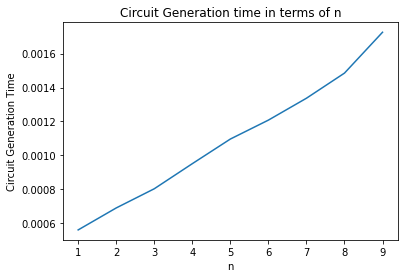

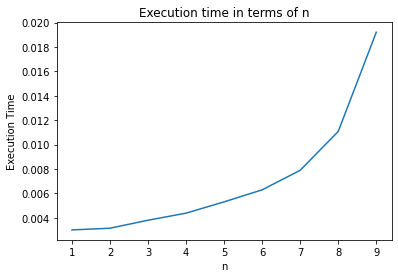

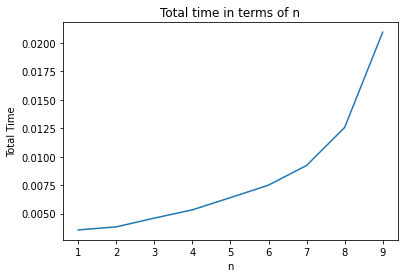

In [22]:
circuitTimes = []
executionTimes = []
totalTimes = []
for n in range(1, 10):
    ct = 0
    et = 0
    tt = 0
    for i in range(100):
        (circuit, execution) = runMainCircuitBV(n, False)
        ct += circuit
        et += execution
        tt += circuit + execution
    circuitTimes.append(ct / 100)
    executionTimes.append(et / 100)
    totalTimes.append(tt / 100)

x_axis = [1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.plot(x_axis, circuitTimes)
plt.title('Circuit Generation time in terms of n')
plt.ylabel('Circuit Generation Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, executionTimes)
plt.title('Execution time in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show() 

plt.plot(x_axis, totalTimes)
plt.title('Total time in terms of n')
plt.ylabel('Total Time')
plt.xlabel('n')
plt.show() 